In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Dense, Input, GRU, Dropout
from keras.callbacks import ModelCheckpoint
from keras.saving import load_model

from sklearn.preprocessing import MinMaxScaler

from scripts.process_dataset import read_dataset, read_simulation
from utils import plot_loss, draw_prediction

2025-04-29 22:21:14.708707: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
def get_lookback_model(Na, Nb, X, Y):
    model = Sequential([
        Input(shape=X.shape[1:]),
        GRU(Na, return_sequences=True),
        GRU(Nb),
        Dense(Y.shape[1])
    ])
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    checkpoint = ModelCheckpoint(
        "toto.keras",
        #f"{folder_name}/{patch}.keras",  # Filepath to save the best model
        monitor="val_loss",  # Metric to monitor (e.g., validation accuracy)
        save_best_only=True,  # Save only the best model
        mode="min",  # "max" if monitoring validation accuracy, "min" for loss
        verbose=0  # Display messages when saving
    )
    model.fit(X, Y, epochs=50, batch_size=180, validation_split=0.2, verbose=0, callbacks=[checkpoint])
    return model

In [3]:
def moving_predict(X, model, scaler, lookback, time):
    pred = np.zeros((time, X.shape[2]))
    real = np.zeros_like(pred)
    real[:lookback, :] = X_trans[0]
    real[lookback:, :] = X_trans[1:time-lookback+1, -1, :]
    pred[:lookback, :] = X_trans[0]
    for i in range(lookback, time):
        pred[i, :70] = model.predict(pred[i-lookback:i, :].reshape(1, lookback, -1), verbose=0).reshape(-1)
        pred[i, 70:] = X_trans[i-lookback+1, -1, 70:]
    pred = scaler.inverse_transform(pred)
    real = scaler.inverse_transform(real)
    return real, pred

In [4]:
def add_zeros_col_like(Y, X):
    return np.concatenate((Y, np.zeros((Y.shape[0], X.shape[1]-Y.shape[1]))), axis=1)

In [5]:
DATASET_NAME = "truc"
DATASET_PATH = f"../dataset/{DATASET_NAME}"
LOOKBACK = 20
X, Y = read_dataset(f"{DATASET_PATH}/train", LOOKBACK)
X_scaler = read_dataset(f"{DATASET_PATH}/train")[0]
X_scaler = X_scaler.reshape((X_scaler.shape[0], X_scaler.shape[2]))
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_scaler)
X_trans = np.zeros_like(X)
for i in range(LOOKBACK):
    X_trans[:, i, :] = scaler.transform(X[:, i, :])
Y_extended = add_zeros_col_like(Y, X_scaler)
Y_trans = scaler.transform(Y_extended)[:, :Y.shape[1]]

In [10]:
Y_trans.shape

(89820, 70)

In [23]:
N = 60
model_lookback = get_lookback_model(200, 100, X_trans[:N*180, :, :], Y_trans[:N*180, :])

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_10 (GRU)                    │ (None, 20, 200)        │       169,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_11 (GRU)                    │ (None, 100)            │        90,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 70)             │         7,070 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,870 (1.02 MB)

 Trainable params: 266,870 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

2025-04-29 22:47:48.495982: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 55296000 exceeds 10% of free system memory.
2025-04-29 22:47:58.199160: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 13824000 exceeds 10% of free system memory.


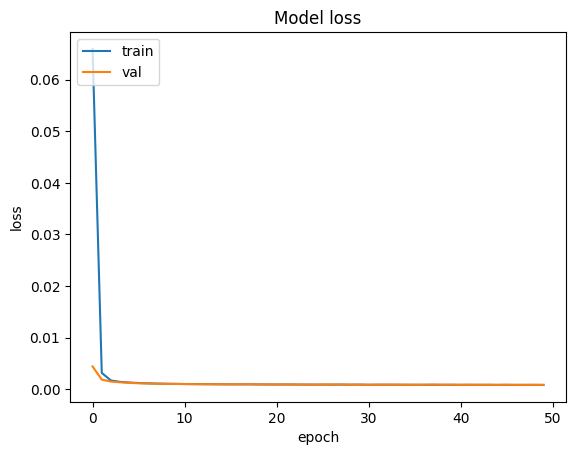

0.0008371977019123733


In [24]:
plot_loss(model_lookback)
print(min(model_lookback.history.history["val_loss"]))

In [26]:
real, pred = moving_predict(X_trans[N:, :], model_lookback, scaler, LOOKBACK, 80)
real = scaler.transform(real)
pred = scaler.transform(pred)
print(np.mean(np.square(real-pred)))

0.0008374561252321334


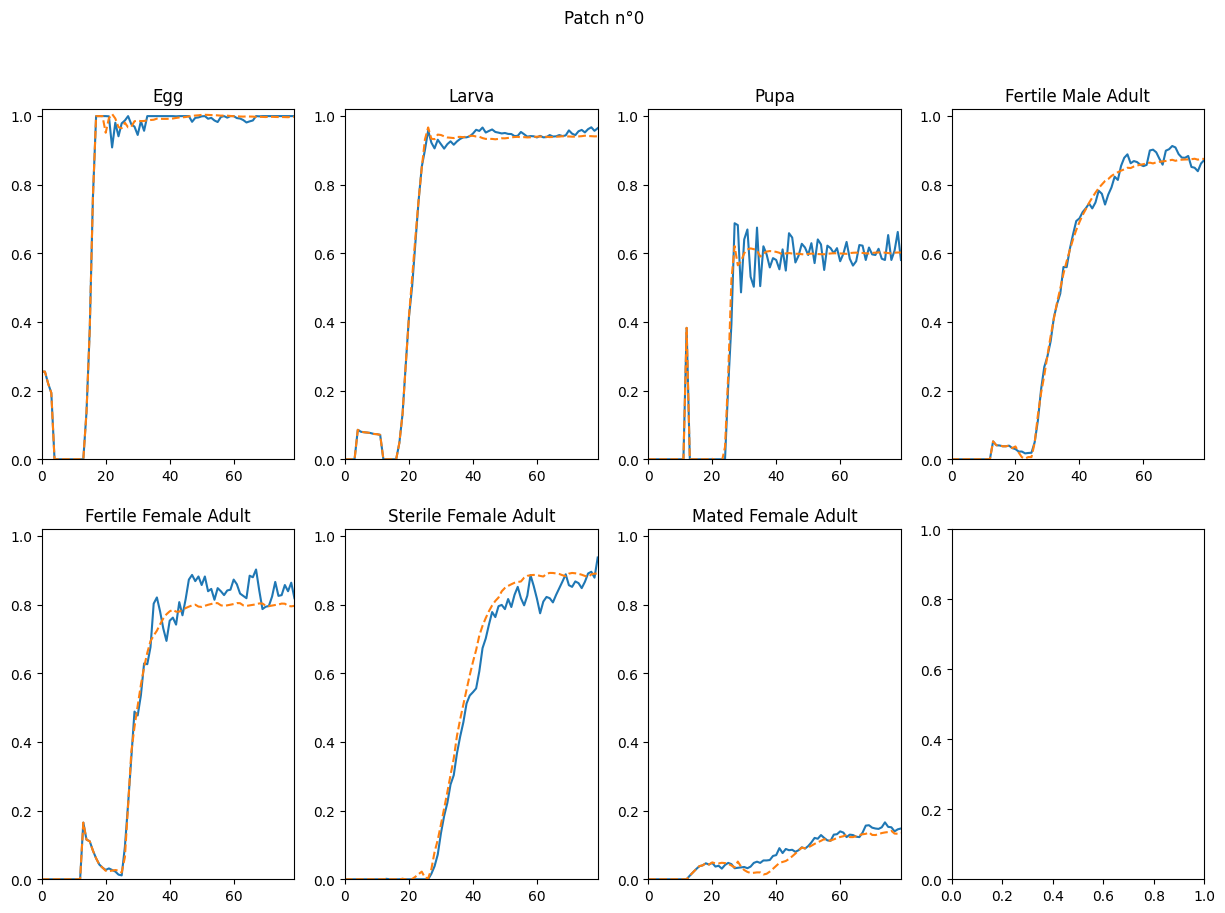

In [27]:
draw_prediction(real, pred, 0)